In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns
from scipy import ndimage

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 96

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry'] #, 'disgusted', 'afraid'
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [4]:
df_fer = pd.read_csv('../data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('../data/ferplus2013.csv').iloc[:, [2, 3, 4, 5, 6]]
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 26811


In [5]:
# ---- Normal Dataset ----
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
images_raw = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    images.append(transform(img))
    images_raw.append(img)
    labels.append(label_np[i])

# ---- Large Dataset ----
# transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.RandomRotation(30),
# ])

# images_np = np.array(df['pixels'])
# label_np = np.array(df['emotion'])

# images = []
# images_raw = []
# labels = []

# for i in range(df.shape[0]):
#     for j in range(4):
#         b = bytes(int(p) for p in images_np[i].split())
#         img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
#         transformed_img = transform(img)
#         transformed_img[transformed_img == 0] = 0.5
#         images.append(transformed_img)

#         images_raw.append(img)
#         labels.append(label_np[i])

## Filtering

In [6]:
kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

In [7]:
images_filtered = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for i in range(len(images)):
    img = images[i].squeeze(0)

    filtered = np.zeros_like(img)
    for cm in kirsch_compass_masks:
        k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
        filtered = np.add(filtered, k)

    filtered = transform(filtered)
    images_filtered.append(filtered)

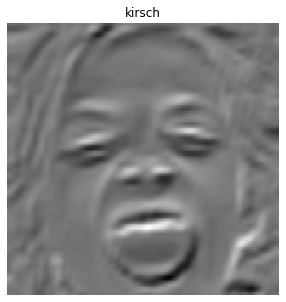

In [8]:
img = images_filtered[random.randint(0, len(images_filtered)-1)]

plt.figure(figsize=(5,5))
plt.title('kirsch')
plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray')

In [9]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096


In [10]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images_filtered[:train_len]
train_labels = labels[:train_len]
test_images = images_filtered[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21448 (80.0%)
test length: 5363 (20.0%)


In [11]:
BATCH_SIZE = 32


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [ 2.848  3.015  7.771  8.963 12.991] 

get_loader():
  class weights: [ 2.732  3.175  7.65   9.492 12.052] 



-----
# SqueezeNet Model

In [12]:
import torch.nn.init as init

import time

from torchvision.utils import _log_api_usage_once

# Batch size during training, remember to change the global one as well
batch_size = BATCH_SIZE

# Number of training epochs
num_epochs = 45

# Learning rate for optimizers
lr = 0.0001

In [13]:
# Function for displaying predictions for a few images, in this case 6.
#print(test_set[0])

class_names = CLASSES
print(class_names)

def visualize_expression_model(model, num_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0), cmap="gray")

                if images_so_far == num_images:
                    return

['neutral', 'happy', 'surprised', 'sad', 'angry']


In [14]:
loss_train = []
accuracy_train = []

def train_expression_model(model, data, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients, and use backpropagatation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    loss_train.append(epoch_loss)
    accuracy_train.append(epoch_acc)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [15]:
loss_test = []
accuracy_test = []
y_actual = []
y_pred = []

def test_expression_model(model, data, criterion):
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predy = model(inputs)

        y_actual.extend(labels.cpu())
        y_pred.extend(predy.argmax(1).cpu())
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    loss_test.append(epoch_loss)
    accuracy_test.append(epoch_acc)

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [16]:
# Pytorch SqueezeNet, https://pytorch.org/vision/0.12/_modules/torchvision/models/squeezenet.html

class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class Facial_Expression_Network_SqueezeNet(nn.Module):
    def __init__(self, version: str = "1_0", num_classes: int = NUM_CLASSES, dropout: float = 0.5) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.num_classes = num_classes
        if version == "1_0": # train 88, test 76    (%), LR 0.0001
            self.features = nn.Sequential(
                nn.Conv2d(1, 96, kernel_size=7, stride=2), # Changed from 3 channels to 1
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == "1_1": # train 96, test 75  (%), 14 min, LR 0.0005
            self.features = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, stride=2), # Changed from 3 channels to 1
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError(f"Unsupported SqueezeNet version {version}: 1_0 or 1_1 expected")

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, 
            nn.ReLU(inplace=True), 
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [17]:
expression_model = Facial_Expression_Network_SqueezeNet().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(expression_model.parameters(), lr=lr, momentum = 0.9)
#optimizer = torch.optim.Adam(expression_model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 1 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.00001)

In [18]:
for epoch in range(1, (num_epochs+1)):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print()
    train_expression_model(expression_model, train_loader, loss_fn, optimizer)
    test_expression_model(expression_model, test_loader, loss_fn)
    scheduler.step

# Normal dataset: version 1_0
#   Train: Loss = 0.0105, Acc = 0.8758
#   Test: Loss = 0.0264, Acc = 0.7632
#   Time = 9 min
#   Epoks = 45

# Normal dataset: version 1_1
#   Train: Loss = 0.0119, Acc = 0.8566
#   Test: Loss = 0.0281, Acc = 0.7227
#   Time = 9
#   Epoks = 75

# Large dataset (x4): 
#   Train: Loss = , Acc =
#   Test: Loss = , Acc = 
#   Time = 
#   Epoks = 

Epoch 1/45



c:\Users\Ludvi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.0504 Acc: 0.2014
test Loss: 0.0504 Acc: 0.2370
Epoch 2/45

train Loss: 0.0502 Acc: 0.2137
test Loss: 0.0501 Acc: 0.2379
Epoch 3/45

train Loss: 0.0497 Acc: 0.2656
test Loss: 0.0489 Acc: 0.2868
Epoch 4/45

train Loss: 0.0480 Acc: 0.3193
test Loss: 0.0462 Acc: 0.3435
Epoch 5/45

train Loss: 0.0450 Acc: 0.3814
test Loss: 0.0408 Acc: 0.4546
Epoch 6/45

train Loss: 0.0407 Acc: 0.4456
test Loss: 0.0382 Acc: 0.4887
Epoch 7/45

train Loss: 0.0372 Acc: 0.5147
test Loss: 0.0364 Acc: 0.5264
Epoch 8/45

train Loss: 0.0353 Acc: 0.5471
test Loss: 0.0375 Acc: 0.5256
Epoch 9/45

train Loss: 0.0326 Acc: 0.5870
test Loss: 0.0308 Acc: 0.6207
Epoch 10/45

train Loss: 0.0314 Acc: 0.6022
test Loss: 0.0302 Acc: 0.6386
Epoch 11/45

train Loss: 0.0298 Acc: 0.6277
test Loss: 0.0340 Acc: 0.5777
Epoch 12/45

train Loss: 0.0291 Acc: 0.6423
test Loss: 0.0293 Acc: 0.6360
Epoch 13/45

train Loss: 0.0278 Acc: 0.6533
test Loss: 0.0281 Acc: 0.6681
Epoch 14/45

train Loss: 0.0267 Acc: 0.6699
test Loss: 0.02

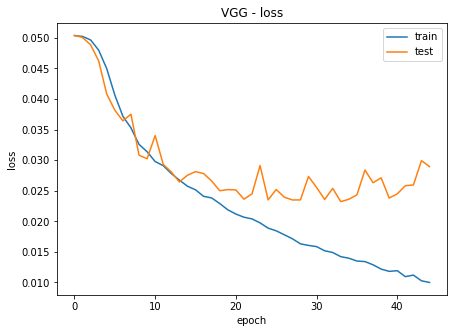

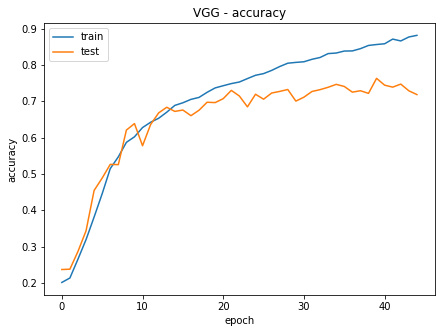

In [19]:
def plot_metric(train, test, metric, title):
    plt.figure(figsize = (7, 5))

    train = torch.tensor(train, device='cpu')
    test = torch.tensor(test, device='cpu')

    with torch.no_grad():
        plt.plot(range(len(train)), train, label = "train")
        plt.plot(range(len(test)), test, label = "test")
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()

    # plt.savefig(f'{title}.png')
    plt.show()


plot_metric(loss_train, loss_test, 'loss', 'VGG - loss')
plot_metric(accuracy_train, accuracy_test, 'accuracy', 'VGG - accuracy')

Text(87.0, 0.5, 'Actual')

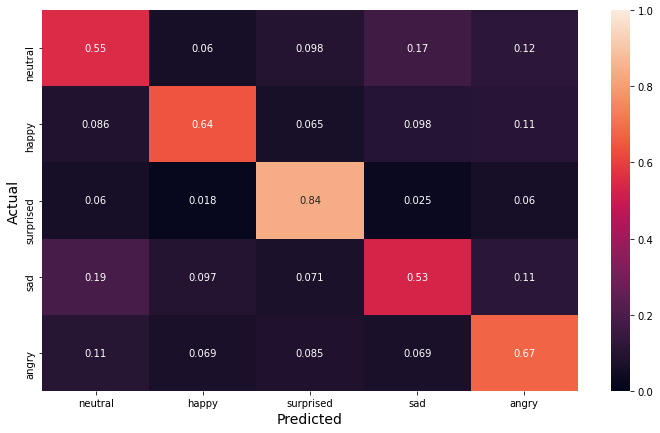

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


counts = np.array([(np.array(y_actual) == i).sum() for i in range(NUM_CLASSES)]).reshape(-1, 1)
cf_matrix = confusion_matrix(y_actual, y_pred)
cf_matrix_norm = cf_matrix / counts

df_cm = pd.DataFrame(cf_matrix_norm, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), vmin=0, vmax=1)
s.set_xlabel('Predicted', fontsize=14)
s.set_ylabel('Actual', fontsize=14)

# plt.savefig('confusion_matrix.png')

##### End of VGG model
-----

In [21]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images_filtered, labels) in enumerate(train_loader):
    for i in range(len(images_filtered)):
        samples_train[labels[i].item()] += 1

for idx, (images_filtered, labels) in enumerate(test_loader):
    for i in range(len(images_filtered)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    4367                 1092
happy                      4266                 1120
surprised                  4247                 1015
sad                        4271                 1066
angry                      4297                 1070


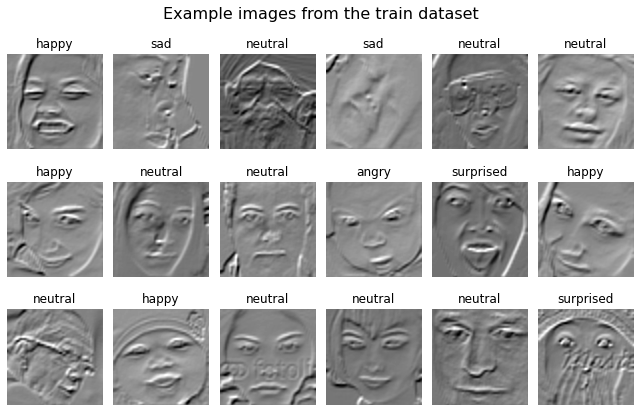

In [22]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')